In [60]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [61]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [62]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [63]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [64]:



df = getQuotes(frameM30, 2023)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
9835,1697232600,1.05078,1.05119,1.05047,1.05107,2348,9,0
9836,1697234400,1.05107,1.05137,1.05089,1.05108,2079,9,0
9837,1697236200,1.05108,1.05154,1.05103,1.05134,1835,9,0
9838,1697238000,1.05134,1.05135,1.05074,1.05081,782,9,0


In [65]:




def macd(df, shortEmaPeriod, longEmaPeriod, signalEmaPeriod):
    df[f'ema-{shortEmaPeriod}'] = ta.ema(df['close'], length=shortEmaPeriod)
    df[f'ema-{longEmaPeriod}'] = ta.ema(df['close'], length=longEmaPeriod)
    df['macdline'] = df[f'ema-{shortEmaPeriod}'] - df[f'ema-{longEmaPeriod}']
    df['macdsignal'] = ta.ema(df['macdline'], signalEmaPeriod)
    df['macdoscillator'] = df['macdline'] - df['macdsignal']
    return df





In [66]:

shortEmaPeriod = 12
longEmaPeriod = 26
signalEmaPeriod = 9

df = macd(df, shortEmaPeriod, longEmaPeriod, signalEmaPeriod)

df = df.dropna()

df


,time,open,high,low,close,tick_volume,spread,real_volume,ema-12,ema-26,macdline,macdsignal,macdoscillator
25,1672662600,1.06819,1.06864,1.06736,1.06830,1317,7,0,1.068388,1.069055,-0.000667,-0.000667,0.000000
26,1672664400,1.06830,1.06850,1.06800,1.06819,990,7,0,1.068358,1.068991,-0.000633,-0.000660,0.000027
27,1672666200,1.06815,1.06860,1.06781,1.06835,888,7,0,1.068357,1.068943,-0.000587,-0.000645,0.000058
28,1672668000,1.06833,1.06866,1.06751,1.06837,1300,7,0,1.068359,1.068901,-0.000542,-0.000625,0.000082
29,1672669800,1.06837,1.06864,1.06772,1.06822,1665,7,0,1.068337,1.068851,-0.000513,-0.000602,0.000089
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9835,1697232600,1.05078,1.05119,1.05047,1.05107,2348,9,0,1.051139,1.052045,-0.000906,-0.000920,0.000014
9836,1697234400,1.05107,1.05137,1.05089,1.05108,2079,9,0,1.051130,1.051973,-0.000844,-0.000905,0.000061
9837,1697236200,1.05108,1.05154,1.05103,1.05134,1835,9,0,1.051162,1.051927,-0.000764,-0.000877,0.000112
9838,1697238000,1.05134,1.05135,1.05074,1.05081,782,9,0,1.051108,1.051844,-0.000736,-0.000848,0.000112


In [67]:

buyIndices=[]
sellIndices=[]

buys=[]
sells=[]

position = None

sl = 0.5 / 100
tp = 1.5 / 100

slamount = None
tpamount = None

for i in range(len(df)):
    if (i > 0) and (position is None) and (df.iloc[i]['macdoscillator'] > 0) and (df.iloc[i - 1]['macdoscillator'] < 0):
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        position = 'long'
        slamount = df.iloc[i]['close'] - (sl * df.iloc[i]['close'])
        tpamount = df.iloc[i]['close'] + (tp * df.iloc[i]['close'])
    if (i > 0) and (position == 'long') and (
        (
            (df.iloc[i]['macdoscillator'] < 0) and
            (df.iloc[i - 1]['macdoscillator'] > 0)
        ) or (
            df.iloc[i]['close'] <= slamount
        ) or (
            df.iloc[i]['close'] >= tpamount
        )
    ):
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])
        position = None
        slamount = None
        tpamount = None



In [68]:

print(buys)
print(sells)

print(buyIndices)
print(sellIndices)


[1.06626, 1.05713, 1.06236, 1.06257, 1.06197, 1.05196, 1.05075, 1.05421, 1.06623, 1.07181, 1.07473, 1.07398, 1.0737700000000001, 1.07448, 1.07444, 1.0749, 1.07495, 1.0763, 1.07643, 1.07751, 1.08237, 1.08249, 1.08191, 1.0824799999999999, 1.08278, 1.0832, 1.07891, 1.07849, 1.07934, 1.08217, 1.08439, 1.08386, 1.08679, 1.08818, 1.08934, 1.08838, 1.08901, 1.08656, 1.0881, 1.0852, 1.08434, 1.08355, 1.08712, 1.09773, 1.09087, 1.07889, 1.07714, 1.07242, 1.07043, 1.07579, 1.07157, 1.07224, 1.06779, 1.07578, 1.07374, 1.07235, 1.06842, 1.06835, 1.06386, 1.06404, 1.06967, 1.06864, 1.06728, 1.0669, 1.06624, 1.06738, 1.06499, 1.06458, 1.06093, 1.06135, 1.05952, 1.05514, 1.05509, 1.06154, 1.05827, 1.05972, 1.06219, 1.06243, 1.06361, 1.0633, 1.06482, 1.06542, 1.05489, 1.05485, 1.05469, 1.05737, 1.05949, 1.05963, 1.06213, 1.06921, 1.073, 1.07222, 1.07108, 1.07532, 1.05564, 1.06208, 1.06118, 1.06707, 1.06874, 1.07325, 1.07797, 1.07985, 1.08515, 1.09236, 1.08229, 1.07557, 1.07661, 1.08068, 1.08286, 1.084

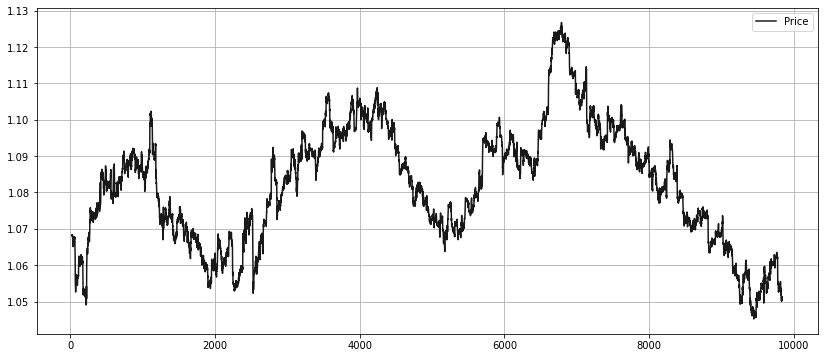

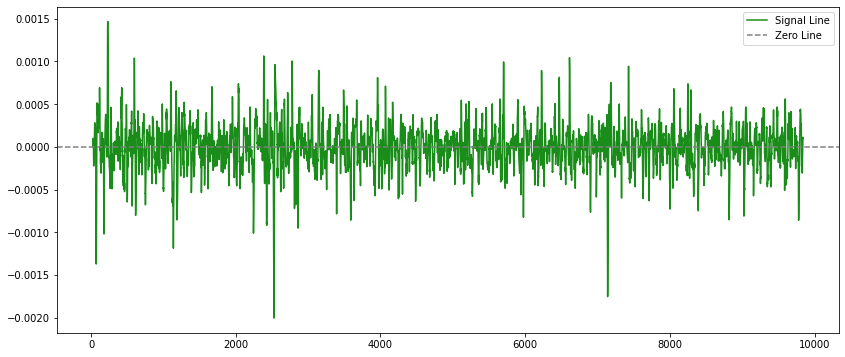

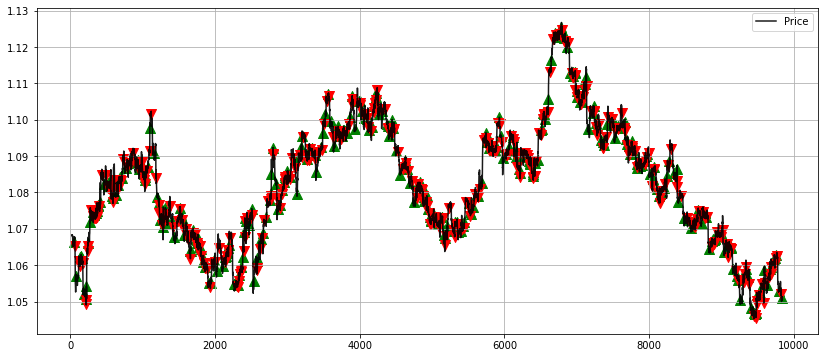

In [69]:


plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize = (14, 6))
plt.plot(df['macdoscillator'], label='Signal Line', c='green', linewidth = 1.5, alpha=0.9)
plt.axhline(y=0, color='gray', linestyle='--', label='Zero Line')
plt.legend()
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()


In [70]:


brokerage = 1 / 100

wins = 0
losses = 0

profit = 0
loss = 0

averageprofit = 0
averageloss = 0

netresult = ''

for i in range(len(sells)):
    maximum = max(sells[i], buys[i])
    brokerageAmount = brokerage * maximum
    diff = sells[i] - buys[i] - brokerageAmount
    if (diff > 0):
        wins += 1
        profit += diff
    if (diff < 0):
        losses += 1
        loss += abs(diff)

if (profit > loss):
    netresult = 'Win'
elif (profit == loss):
    netresult = 'None'
else:
    netresult = 'Loss'

averageprofit = profit / wins
averageloss = loss / losses
hitratio = (wins / (wins + losses)) * 100
profitfactor = (profit / loss)
expectancy = (averageprofit * hitratio) - (averageloss * (1 - hitratio))
riskreward = (averageprofit / averageloss)

print(f'''
    Net result = {netresult}
    Hit ratio = {hitratio} %
    Profit factor = {profitfactor} {{currency}}
    Expectancy = {expectancy} {{currency}}
    Realised risk reward ratio = {riskreward} {{currency}}
''')







    Net result = Loss
    Hit ratio = 0.27548209366391185 %
    Profit factor = 0.00022345816483021287 {currency}
    Expectancy = -0.007598603190874095 {currency}
    Realised risk reward ratio = 0.08089185566853706 {currency}

